In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path as P
import os
from glob import glob
import matplotlib.cm as cm

feature_path = P('/root/dj/code/CenterPoint-KITTI/output/IA-SSD-GAN-vod-aug/debug/eval/inter_feats/main_branch')
feature_layer_list = sorted(list(feature_path.glob('*')))
group_fnames = sorted(glob(str(feature_layer_list[0]/'*_group*')))
group_fnames = [x.split('/')[-1] for x in group_fnames]
center_fnames = sorted(glob(str(feature_layer_list[0]/'*center*')))
center_fnames = [x.split('/')[-1] for x in center_fnames]

lidar_path = P('/root/dj/code/CenterPoint-KITTI/output/IA-SSD-GAN-vod-aug/debug/eval/inter_feats/attach')
lidar_layer_list = sorted(list(lidar_path.glob('*')))
lidar_group_fnames = sorted(glob(str(lidar_layer_list[0]/'*_group*')))
lidar_group_fnames = [x.split('/')[-1] for x in lidar_group_fnames]
lidar_center_fnames = sorted(glob(str(lidar_layer_list[0]/'*center*')))
lidar_center_fnames = [x.split('/')[-1] for x in lidar_center_fnames]


In [2]:
from scipy.spatial.transform import Rotation as R
import open3d as o3d
from visualize_point_based import transform_anno, drawBEV

def get_rotation(yaw):
    # x,y,_ = arr[:3]
    # yaw = np.arctan(y/x)
    angle = np.array([0, 0, yaw])
    r = R.from_euler('XYZ', angle)
    return r.as_matrix()

def get_bbx_param(obj_info):

    center = obj_info[:3]
    extent = obj_info[3:6] + np.array([0, 0, 10])
    angle = -obj_info[6]
    # center[-1] += 0.5 * extent[-1]

    rot_m = get_rotation(angle)
    
    obbx = o3d.geometry.OrientedBoundingBox(center.T, rot_m, extent.T)
    return obbx
    

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# load pooling weights
weights_path = P('/root/dj/code/CenterPoint-KITTI/output/IA-SSD-GAN-vod-aug/debug/eval/checkpoint_epoch_11/final_result/data')

radar_weights_path = weights_path/'main_pw'
lidar_weights_path = weights_path/'attach_pw'
radar_weights_file = sorted(list(radar_weights_path.glob('*.npy')))
lidar_weights_file = sorted(list(lidar_weights_path.glob('*.npy')))


In [4]:
import pickle
root_path = P('/root/dj/code/CenterPoint-KITTI/output/IA-SSD-GAN-vod-aug/debug/eval/checkpoint_epoch_11')
    # ia-ssd
    # root_path = P('/root/dj/code/CenterPoint-KITTI/output/IA-SSD-vod-radar/iassd_128_all/eval/checkpoint_epoch_100')
    
    # root_path = P('/root/dj/code/CenterPoint-KITTI/output/pointpillar_vod_lidar/filter5/eval/eval_with_train/epoch_80/val')
save_path = root_path / 'vis_pooling'
save_path.mkdir(exist_ok=True)
color_dict = {}

gt_save_dir = root_path / 'GT_all_bev'
pred_save_dir = root_path / 'pred_bev'
gt_save_dir.mkdir(exist_ok=True)
pred_save_dir.mkdir(exist_ok=True)

# for i, v in enumerate(cls_name):
#     color_dict[v] = label_color_palette_2d[v]
# load gt
with open(str(root_path / 'gt.pkl'), 'rb') as f:
    gt = pickle.load(f)

# load det
with open(str(root_path / 'dt.pkl'), 'rb') as f:
    dt = pickle.load(f)

# load centers
with open(str(root_path / 'centers.pkl'), 'rb') as f:
    centers = pickle.load(f)

# load centers_origin
with open(str(root_path / 'centers_origin.pkl'), 'rb') as f:
    centers_origin = pickle.load(f)

# load input points (after sampling to 512 points)
with open(str(root_path / 'points.pkl'), 'rb') as f:
    points = pickle.load(f)

In [5]:

def feat2coord(lidar_feat):
    coord = lidar_feat[:, :3, :, :]
    return coord

def sum_weights(coord, weights):
    pass

def getSumHeat(lidar_weights_file, idx, lidar_group_coords):
    lidar_pw = np.load(lidar_weights_file[idx], allow_pickle=True).flat[0]
    l1_pw = lidar_pw['0.pool_weights.1']
    group_coord = lidar_group_coords
    vidx = np.nonzero(l1_pw)
    pwv = l1_pw[vidx]
    nonzero_coord = group_coord[vidx[0], :, vidx[2], vidx[3]]
    uniq_coord, _ = np.unique(nonzero_coord, axis=0, return_index=True)
    sum_heat = np.zeros([uniq_coord.shape[0]])

    for uniq_coord_idx in range(uniq_coord.shape[0]):
        nonzero_coord[nonzero_coord == uniq_coord[uniq_coord_idx,:]]

        test_idx = np.argwhere((nonzero_coord == uniq_coord[uniq_coord_idx,:]).all(1))
        pwv[test_idx].sum()
        sum_heat[uniq_coord_idx] = pwv[test_idx].sum()
    return uniq_coord, sum_heat
def change_lidar_format(lidar_pts):
    lidar_pts_vis = lidar_pts.reshape([-1, 3])
    npoints, _ = lidar_pts_vis.shape
    lidar_pts_final = np.zeros([npoints, 4])
    lidar_pts_final[:, 1:] = lidar_pts_vis
    return lidar_pts_final


 84%|████████▎ | 582/696 [36:00<07:03,  3.71s/it]  


ValueError: zero-size array to reduction operation maximum which has no identity

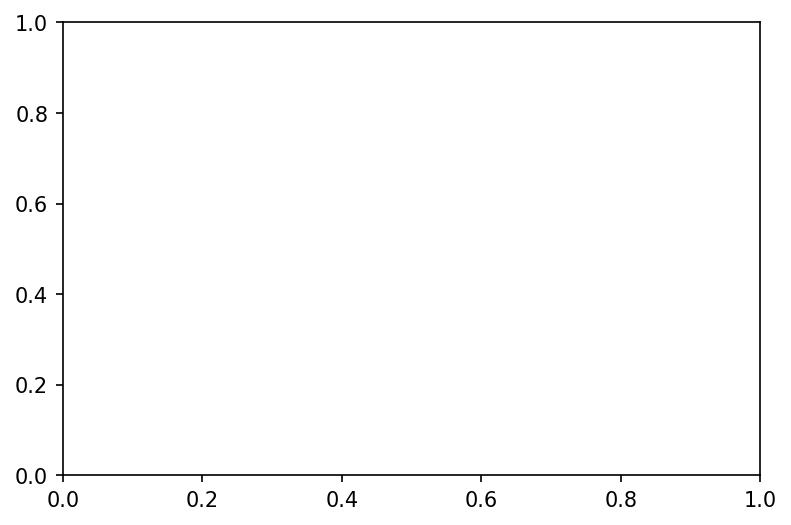

In [18]:
from vod.visualization.settings import label_color_palette_2d
from matplotlib.lines import Line2D

features_list = []
center_list = []
idx = 550
keys = list(gt.keys())
cls_name = ['Car','Pedestrian', 'Cyclist', 'Others']
color_dict = {}
for i, v in enumerate(cls_name):
    color_dict[v] = label_color_palette_2d[v]
from tqdm import tqdm
for idx in tqdm(range(600, len(keys))):
    fix_frame_id = keys[idx]
    # for layer in feature_layer_list:
    #     full_group_name = str(layer / group_fnames[idx])
    #     full_center_name = str(layer / center_fnames[idx])
    #     try:
    #         features_list += [np.load(full_group_name)]
    #         center_list += [np.load(full_center_name)]
    #     except:
    #         pass

    # load lidar pts
    lidar_features_list = []
    lidar_center_list = []
    for layer in lidar_layer_list:
        full_group_name = str(layer / lidar_group_fnames[idx])
        full_center_name = str(layer / lidar_center_fnames[idx])
        try:
            lidar_features_list += [np.load(full_group_name)]
            lidar_center_list += [np.load(full_center_name)]
        except:
            pass
    lidar_features_list[1].shape

    lidar_group_coords = lidar_features_list[0][:, :3, :, :]
    lidar_vis = change_lidar_format(lidar_center_list[0])
    

    
    ax = plt.gca()
    pts, heatmap = getSumHeat(lidar_weights_file, idx, lidar_group_coords)
    # heatmap = -heatmap
    heatmap[heatmap<0] = 0
    heatmap = heatmap / heatmap.max() *30
    hot_c = cm.plasma(heatmap)
    ext_legends = [Line2D([0], [0], marker='o', color='w', label='transfer points',
                            markerfacecolor='magenta', markersize=10)]
    drawBEV(ax, lidar_vis, None, gt[fix_frame_id], color_dict, fix_frame_id, 'lidar points with GT bbx', ext_legends=ext_legends)
    heatmap = heatmap.reshape([-1,1])
    sort_ind = np.argsort(heatmap, axis=0)
    sort_c = np.take_along_axis(heatmap, sort_ind, axis=0)
    pts_x = np.take_along_axis(pts[:, 0:1], sort_ind, axis=0)
    pts_y = np.take_along_axis(pts[:, 1:2], sort_ind, axis=0)
    ax.scatter(pts_x, pts_y, c='magenta', s=sort_c, edgecolors='black', linewidths=0.1)
    # drawBEV(ax, None, None, gt[fix_frame_id], color_dict, fix_frame_id, 'lidar points with GT bbx', ext_legends=ext_legends)
    plt.xlim(-0,75)
    plt.ylim(-20,20)
    plt.rcParams['figure.dpi'] = 150
    fname = 'transfer_lidar_' + fix_frame_id + '.png'
    plt.savefig(str(save_path/fname))
    plt.cla()

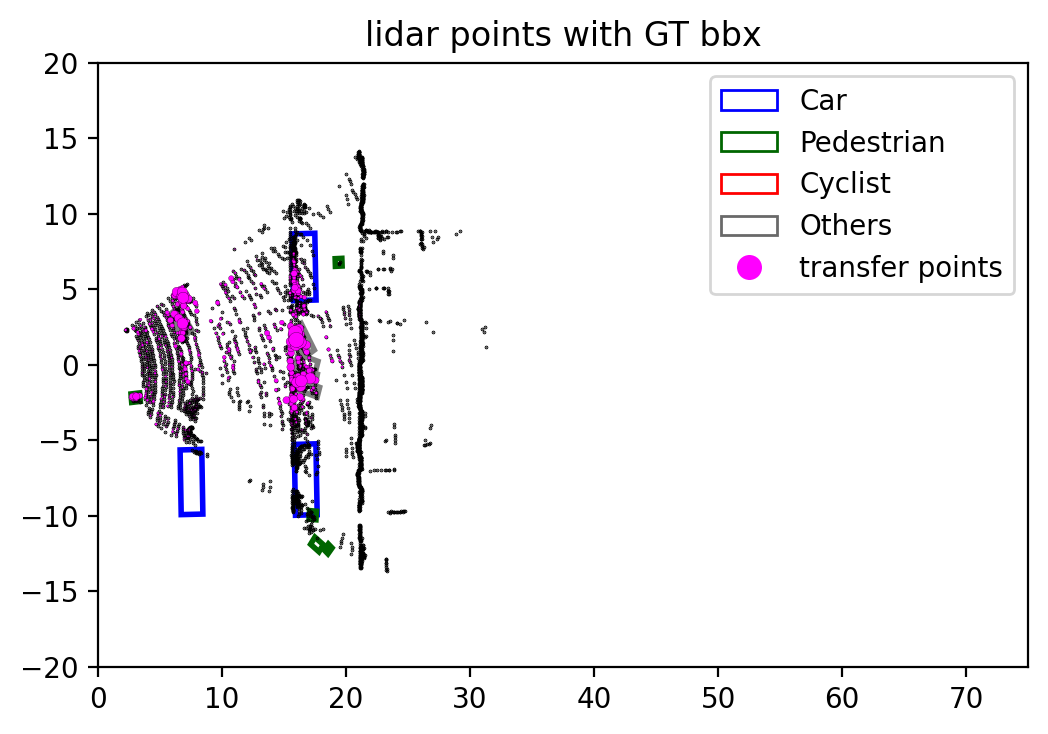

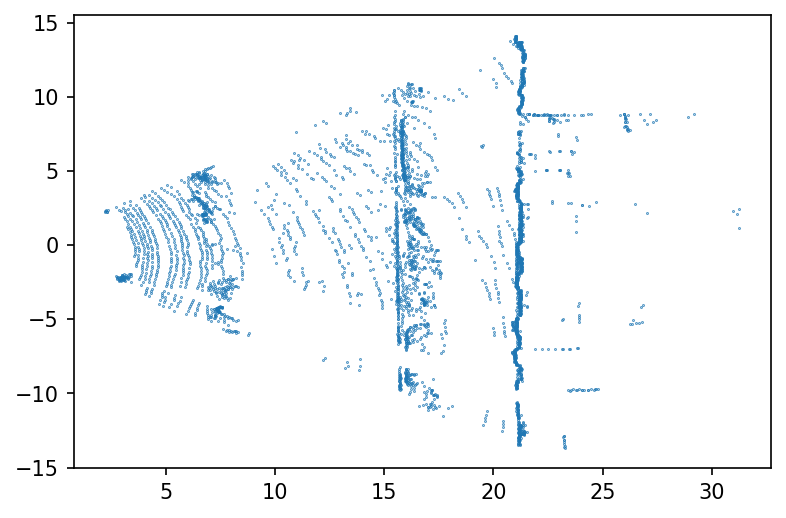

In [29]:
plt.scatter(lidar_center_list[0][0,:,0], lidar_center_list[0][0, :, 1], s=0.1)
plt.show()
def change_lidar_format(lidar_pts):
    lidar_pts_vis = lidar_pts.reshape([-1, 3])
    npoints, _ = lidar_pts_vis.shape
    lidar_pts_final = np.zeros([npoints, 4])
    lidar_pts_final[:, 1:] = lidar_pts_vis
    return lidar_pts_final
lidar_vis = change_lidar_format(lidar_center_list[0])
lidar_pw = np.load(lidar_weights_file[idx], allow_pickle=True).flat[0]

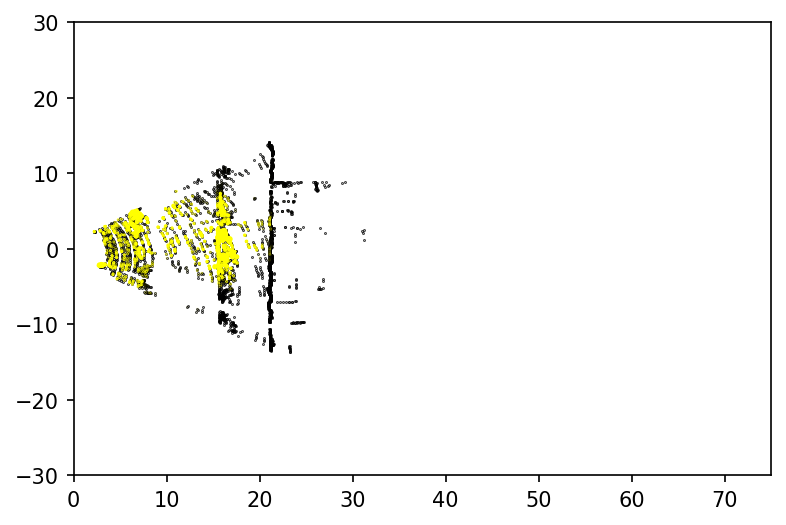

In [30]:
plt.rcParams['figure.dpi'] = 150
# fig, ax = plt.subplots()
# plt.xlim(-0,75)
# plt.ylim(-30,30)
ax = plt.gca()
ax.scatter(lidar_center_list[0][0,:,0], lidar_center_list[0][0, :, 1], s=0.1, c='black')

pts, heatmap = getSumHeat(lidar_weights_file, idx, lidar_group_coords)

# heatmap = -heatmap

# colormap = plt.cm.get_cmap('gnuplot') # 'plasma' or 'viridis'

heatmap[heatmap<0] = 0
heatmap = heatmap / heatmap.max() * 10
hot_c = cm.plasma(heatmap)
ax.scatter(pts[:,0], pts[:,1], c='yellow', s=heatmap)
plt.xlim(-0,75)
plt.ylim(-30,30)
# sm = plt.cm.ScalarMappable(cmap=colormap)
# sm.set_clim(vmin=heatmap.min(), vmax=heatmap.max())
# plt.colorbar(sm)
plt.show()

In [24]:
heatmap.max()

10.0

In [106]:
heatmap.max()


1.0

In [28]:
coord = features_list[0][0, :3, :, :]
feat = features_list[0][0, 3:, :, :]

In [29]:
coord.shape

(3, 512, 32)

In [30]:
cur_center = center_list[3]

In [31]:
feat.shape

(64, 512, 32)

In [32]:
group_features = feat[:, 0, :]

In [33]:
group_features.shape

(64, 32)

In [34]:
t = np.argmax(group_features, axis=1)

In [35]:
feat_idx = np.argmax(feat, axis=-1)

In [36]:
t

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [37]:
feat_idx.shape

(64, 512)

In [38]:
cur_center.shape

(1, 128, 3)

In [39]:
(cur_center[0, :, 0] < 20) & (cur_center[0, :, 0] > 17)

array([ True, False, False, False,  True,  True, False, False,  True,
        True,  True, False, False, False,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True, False, False, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True]

In [19]:
import pickle
root_path = P('/root/dj/code/CenterPoint-KITTI/output/IA-SSD-GAN-vod-aug/debug/eval/checkpoint_epoch_11')
    # ia-ssd
    # root_path = P('/root/dj/code/CenterPoint-KITTI/output/IA-SSD-vod-radar/iassd_128_all/eval/checkpoint_epoch_100')
    
    # root_path = P('/root/dj/code/CenterPoint-KITTI/output/pointpillar_vod_lidar/filter5/eval/eval_with_train/epoch_80/val')
save_path = root_path / 'vis_pooling'
save_path.mkdir(exist_ok=True)
color_dict = {}

gt_save_dir = root_path / 'GT_all_bev'
pred_save_dir = root_path / 'pred_bev'
gt_save_dir.mkdir(exist_ok=True)
pred_save_dir.mkdir(exist_ok=True)

# for i, v in enumerate(cls_name):
#     color_dict[v] = label_color_palette_2d[v]
# load gt
with open(str(root_path / 'gt.pkl'), 'rb') as f:
    gt = pickle.load(f)

# load det
with open(str(root_path / 'dt.pkl'), 'rb') as f:
    dt = pickle.load(f)

# load centers
with open(str(root_path / 'centers.pkl'), 'rb') as f:
    centers = pickle.load(f)

# load centers_origin
with open(str(root_path / 'centers_origin.pkl'), 'rb') as f:
    centers_origin = pickle.load(f)

# load input points (after sampling to 512 points)
with open(str(root_path / 'points.pkl'), 'rb') as f:
    points = pickle.load(f)

In [35]:
keys = list(gt.keys())
fix_frame_id = keys[idx]

In [8]:
from scipy.spatial.transform import Rotation as R
import open3d as o3d
from visualize_point_based import transform_anno, drawBEV

def get_rotation(yaw):
    # x,y,_ = arr[:3]
    # yaw = np.arctan(y/x)
    angle = np.array([0, 0, yaw])
    r = R.from_euler('XYZ', angle)
    return r.as_matrix()

def get_bbx_param(obj_info):

    center = obj_info[:3]
    extent = obj_info[3:6] + np.array([0, 0, 10])
    angle = -obj_info[6]
    # center[-1] += 0.5 * extent[-1]

    rot_m = get_rotation(angle)
    
    obbx = o3d.geometry.OrientedBoundingBox(center.T, rot_m, extent.T)
    return obbx
    



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


(-30.0, 30.0)

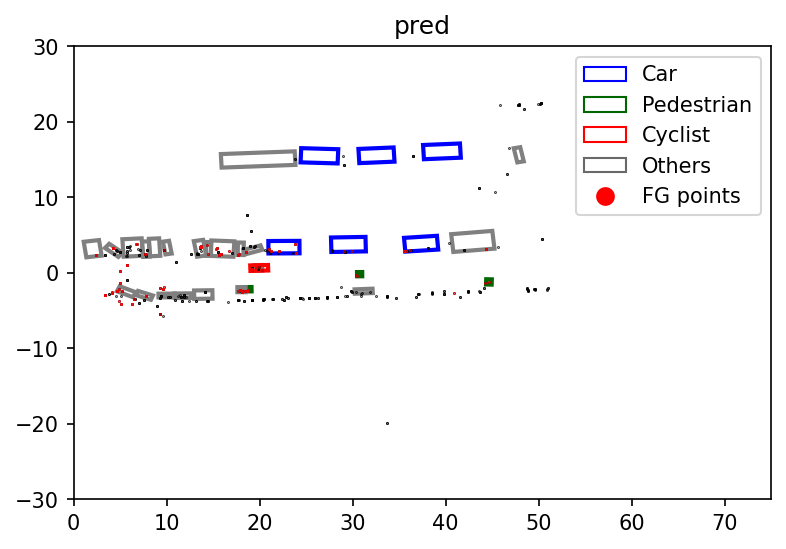

In [25]:
from vod.visualization.settings import label_color_palette_2d
cls_name = ['Car','Pedestrian', 'Cyclist', 'Others']
color_dict = {}
for i, v in enumerate(cls_name):
    color_dict[v] = label_color_palette_2d[v]
ax = plt.gca()

drawBEV(ax, points[fix_frame_id], centers_origin[fix_frame_id], gt[fix_frame_id], color_dict, fix_frame_id, 'pred')

# plt.xlim(-0,75)
# plt.ylim(-30,30)
plt.xlim(-0,75)
plt.ylim(-30,30)



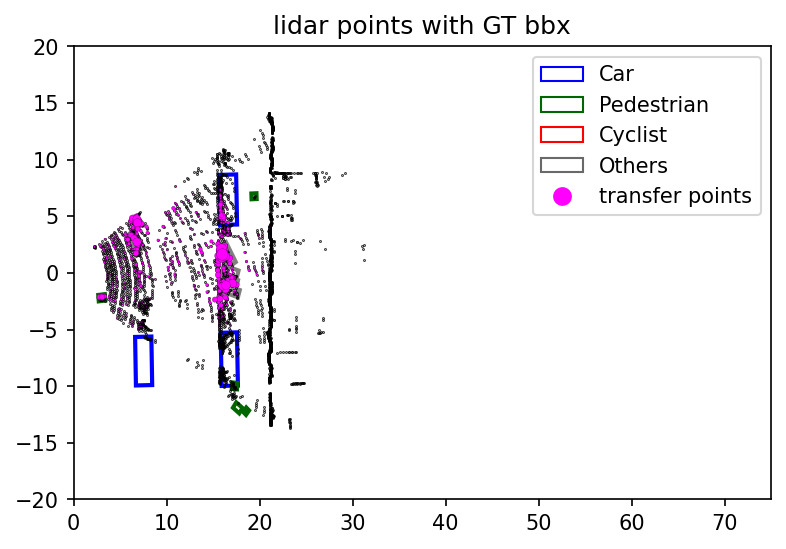

In [37]:
from vod.visualization.settings import label_color_palette_2d
from matplotlib.lines import Line2D
cls_name = ['Car','Pedestrian', 'Cyclist', 'Others']
color_dict = {}
for i, v in enumerate(cls_name):
    color_dict[v] = label_color_palette_2d[v]
ax = plt.gca()
pts, heatmap = getSumHeat(lidar_weights_file, idx, lidar_group_coords)
# heatmap = -heatmap
heatmap[heatmap<0] = 0
heatmap = heatmap / heatmap.max() *30
hot_c = cm.plasma(heatmap)
ext_legends = [Line2D([0], [0], marker='o', color='w', label='transfer points',
                          markerfacecolor='magenta', markersize=10)]
drawBEV(ax, lidar_vis, None, gt[fix_frame_id], color_dict, fix_frame_id, 'lidar points with GT bbx', ext_legends=ext_legends)
heatmap = heatmap.reshape([-1,1])
sort_ind = np.argsort(heatmap, axis=0)
sort_c = np.take_along_axis(heatmap, sort_ind, axis=0)
pts_x = np.take_along_axis(pts[:, 0:1], sort_ind, axis=0)
pts_y = np.take_along_axis(pts[:, 1:2], sort_ind, axis=0)
ax.scatter(pts_x, pts_y, c='magenta', s=sort_c, edgecolors='black', linewidths=0.1)
plt.xlim(-0,75)
plt.ylim(-20,20)
fname = 'transfer_lidar_' + fix_frame_id + '.png'
plt.savefig(str(save_path/fname))

In [167]:
# sort heat map and code
sort_ind = np.argsort(heatmap, axis=0)
sort_ind

array([[3819],
       [1572],
       [2938],
       ...,
       [2987],
       [3032],
       [3079]])

In [32]:
gt.keys()

dict_keys(['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042', '00043', '00044', '00045', '00046', '00047', '00048', '00049', '00050', '00051', '00052', '00053', '00054', '00055', '00056', '00057', '00058', '00059', '00060', '00061', '00062', '00063', '00064', '00065', '00066', '00067', '00068', '00069', '00070', '00071', '00072', '00073', '00074', '00075', '00076', '00077', '00078', '00079', '00080', '00081', '00082', '00083', '00084', '00085', '00086', '00087', '00088', '00089', '00090', '00091', '00092', '00093', '00094', '00095', '00096', '00097', '00098', '00099', '00100', '00101', '00102', '00103', '00104', '00105', '00106', '00107', '00108', '00109',

In [17]:
save_path = root_path / 'vis_pooling'
save_path.mkdir(exist_ok=True)

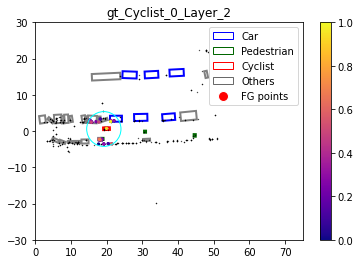

In [54]:

anno_type = 'gt'
if anno_type == 'pred':
    anno = dt[str(idx).zfill(5)][0]
else:
    anno = gt[str(idx).zfill(5)]

cur_class_name = 'Car'
draw_cls_name = ['Car','Pedestrian', 'Cyclist']
for cur_class_name in cls_name:

    select = anno['name'] == cur_class_name
    loc = anno['location'][select]
    yaw = anno['rotation_y'][select]
    extent = anno['dimensions'][select]


    # cur_label_idx = 0


    for cur_label_idx in range(sum(select)):

        x, y, z = transform_anno(loc[cur_label_idx], fix_frame_id)
        dx, dy, dz = extent[cur_label_idx]
        rot_y = yaw[cur_label_idx]
        obj_info = np.array([x, y, z, dx, dy, dz, rot_y])
        box = get_bbx_param(obj_info)


        layer_range = [0, 1, 2]
        for layer_idx in layer_range:
            plt.cla()
            plt.clf()
            cur_center = center_list[layer_idx].squeeze(0)
            cur_grouped = features_list[layer_idx]
            cur_feat = cur_grouped[:, 3:,:,:]
            cur_coords = cur_grouped[:, :3, :, :]
            radius_list = [0.8, 1.6, 4.8, 6.4]
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(cur_center)
            ctr_idx = box.get_point_indices_within_bounding_box(pcd.points)
            # print(ctr_idx)
            if len(ctr_idx ) == 0:
                continue
            ped_center = cur_center[ctr_idx[0],:]
            selected_coords = cur_coords[0, :, ctr_idx[0], :]
            selected_feats = cur_feat[0, :, ctr_idx[0], :]
            selected_feats[selected_feats < 0] = 0
            bins = selected_feats.shape[1]
            max_idx = np.argmax(selected_feats, axis=1)
            hist = np.histogram(max_idx, bins=bins, range=(0, bins))[0]
            c = hist/ sum(hist)
            minval = np.min(c[np.nonzero(c)])
            if minval == 1:
                minval = 0
            norm_c = (c - minval)/(max(c) - minval)
            norm_c[norm_c < 0] = 0
            selected_x = selected_coords[0, :].T
            selected_y = selected_coords[1, :].T

            sort_ind = np.argsort(norm_c, axis=0)
            sorted_x = np.take_along_axis(selected_x, sort_ind, axis=0)
            sorted_y = np.take_along_axis(selected_y, sort_ind, axis=0)
            sorted_c = np.take_along_axis(norm_c, sort_ind, axis=0)

            colormap = plt.cm.get_cmap('plasma') # 'plasma' or 'viridis'

            hot_c = cm.plasma(sorted_c)
            plt.rcParams['figure.dpi'] = 200
            ax = plt.gca()
            title = anno_type + '_' + cur_class_name + '_' + str(cur_label_idx) + '_' + 'Layer_' + str(layer_idx)
            if anno_type == 'gt':
                draw_anno = gt[test_id]
            elif anno_type == 'pred':
                draw_anno = dt[test_id]
            drawBEV(ax, points[test_id], None, draw_anno, color_dict, test_id, title)
            ax.scatter(sorted_x, sorted_y, c=hot_c, s=5)
            circle = plt.Circle(ped_center[0:2], radius_list[layer_idx], fill=False, color='cyan')
            ax.add_patch(circle)
            handle_legend = ax.get_legend_handles_labels()
            plt.xlim(-0,75)
            plt.ylim(-30,30)
            sm = plt.cm.ScalarMappable(cmap=colormap)
            sm.set_clim(vmin=0, vmax=1)
            plt.colorbar(sm)
            fig_name = title + '.png'
            save_fname = str(save_path / fig_name)
            plt.savefig(save_fname)
